In [1]:
from torch.utils.tensorboard import SummaryWriter
tb_summary = SummaryWriter("./Tensorboards/", purge_step=0)

2024-03-08 16:56:01.238216: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 16:56:01.629752: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 16:56:01.629882: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 16:56:01.631095: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 16:56:01.798865: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 16:56:01.804294: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
#create config
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # TODO: the generated image resolution
    channels = 3 # only used for logging
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    #gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    #hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    #hub_private_repo = False
    #overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0
config = TrainingConfig()

In [3]:
#log at tensorboard
tb_summary.add_scalar("image_size", config.image_size, 0)
tb_summary.add_scalar("train_batch_size", config.train_batch_size, 0)
tb_summary.add_scalar("eval_batch_size", config.eval_batch_size, 0)
tb_summary.add_scalar("num_epochs", config.num_epochs, 0)
tb_summary.add_scalar("learning_rate", config.learning_rate, 0)
tb_summary.add_scalar("lr_warmup_steps", config.lr_warmup_steps, 0)
tb_summary.add_scalar("save_image_epochs", config.save_image_epochs, 0)
tb_summary.add_text("mixed_precision", config.mixed_precision, 0) 

In [4]:
#download dataset
from datasets import load_dataset

config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split="train")

Repo card metadata block was not found. Setting CardData to empty.


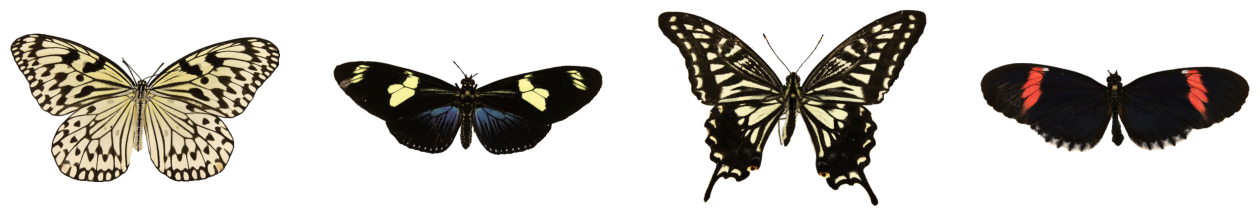

In [5]:
#show examples
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [6]:
#Preprocessing
import torchvision
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"image": images}

dataset.set_transform(transform)

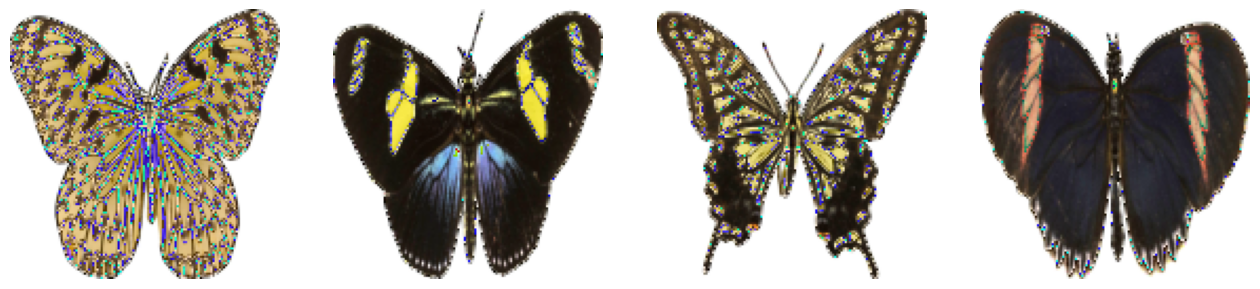

In [7]:
#show preprocessed images. Blue/Green Pixels comes from Normalizing
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]): 
    axs[i].imshow(transforms.functional.to_pil_image(image))
    axs[i].set_axis_off()
fig.show()

In [8]:
#setup dataloader
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [9]:
#create model
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

tb_summary.add_text("model", "UNet2DModel", 0) 

/opt/conda/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [10]:
#check if image size matches
sample_image = dataset[0]["image"].unsqueeze(0)
print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


In [11]:
#setup noise scheduler
import torch
from PIL import Image
from diffusers import DDIMScheduler

noise_scheduler = DDIMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])


tb_summary.add_text("noise_scheduler", "DDIMScheduler(num_train_timesteps=1000)", 0) 

In [12]:
# setup lr scheduler
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

tb_summary.add_text("lr_scheduler", "cosine_schedule_with_warmup", 0) 

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [14]:
#setup evaluation
from diffusers import DDIMPipeline
from diffusers.utils import make_image_grid
import os

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    model.eval()
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images 
    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")
    print("image saved")

In [19]:
#from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os 
import torch.nn as nn 
import torch.nn.functional as F

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    #removed accelerator stuff
    os.makedirs(config.output_dir, exist_ok=True)

    global_step = 0

    
    
    # Now you train the model
    for epoch in range(config.num_epochs):
        model.to(device)
        model.train()
        #progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar = tqdm(total=len(train_dataloader))
        progress_bar.set_description(f"Epoch {epoch}")

        
        for step, batch in enumerate(train_dataloader):
            clean_images = batch["image"]
            clean_images = clean_images.to(device)
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            #with accelerator.accumulate(model):
            # Predict the noise residual
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            #accelerator.backward(loss)
            loss.backward()

            #accelerator.clip_grad_norm_(model.parameters(), 1.0)
            nn.utils.clip_grad_value_(model.parameters(),1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            progress_bar.update(1)
            #log gradient norm 
            parameters = [p for p in model.parameters() if p.grad is not None and p.requires_grad]
            if len(parameters) == 0:
                total_norm = 0.0
            else: 
                total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach()).cpu() for p in parameters]), 2.0).item()
            logs = {"loss": loss.cpu().detach().item(), "lr": lr_scheduler.get_last_lr()[0], "total_norm": total_norm, "step": global_step}
            tb_summary.add_scalar("loss", logs["loss"], global_step)
            tb_summary.add_scalar("lr", logs["lr"], global_step) 
            tb_summary.add_scalar("total_norm", logs["total_norm"], global_step) 
            
            progress_bar.set_postfix(**logs)
            #accelerator.log(logs, step=global_step)
            global_step += 1 

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        #if accelerator.is_main_process:
        #pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
        pipeline = DDIMPipeline(unet=model, scheduler=noise_scheduler)
        pipeline.to(torch.device("cpu"))

        if (epoch) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
            evaluate(config, epoch, pipeline)

        if (epoch) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1: 
            pipeline.save_pretrained(config.output_dir)


tb_summary.add_text("inference_pipeline", "DDIMPipeline", 0) 

In [20]:
train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)    

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
#create python script for ubelix
!jupyter nbconvert --to script "lesion_filling.ipynb"

[NbConvertApp] Converting notebook lesion_filling.ipynb to script
[NbConvertApp] Writing 9926 bytes to lesion_filling.py
